In [1]:
import pandas as pd
import pycountry # map two-letter country codes and names
import requests # web queries

requests.packages.urllib3.disable_warnings()

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


pd.options.display.max_colwidth = -1



###Package summary

In [29]:
print 'pandas', pd.__version__
print 'pycountry 17.5.14'
print 'requests', requests.__version__ 
print 'matplotlib 1.5.0'
print 'numpy', np.__version__

 pandas 0.19.1
pycountry 17.5.14
requests 2.18.1
matplotlib 1.5.0
numpy 1.11.2


###Distribution of adverse effects by countries

In [2]:
loc_url = 'https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20170701]&count=primarysource.reportercountry.exact'
web_response = requests.get(loc_url)
data = web_response.json()

In [3]:
'''
Looks up an ISO 3166 name for a country.
Returns an ISO name or None if a match is not found.
'''
def get_standard_country_name(s):
    if len(s) == 2:
        try:
            return pycountry.countries.get(alpha_2=s).name
        except:
            return None
    elif len(s) > 2:
        # normalise country name to pycountry standard
        stand_s = (s.lower()).title()  
        if ' Of' in stand_s:
            stand_s = stand_s.replace(' Of', ' of')
        
        # ugly workaround for country names with brackets
        if '(' in stand_s:
            stand_s = stand_s.split('(')[0]
            stand_s = stand_s.strip()

        try:
            return pycountry.countries.get(name=stand_s).name
        except KeyError:
            try:
                return pycountry.countries.get(official_name=stand_s).name
            except KeyError:
                try:
                    return pycountry.countries.get(common_name=stand_s).name
                except:
                    print 'country \"', stand_s, '\" not found in list. Leaving as is.'
                    return stand_s # return the original name if nothing found
    else:
        return None

country_df = pd.DataFrame(data['results'])
country_df['country'] = country_df.term.apply(get_standard_country_name)

country_df.sort_values(by='country', inplace=True) # sort in alphabetical order
print country_df.describe()
print 'smallest nr. of entries:', country_df.ix[country_df['count'].idxmin()].country

country " Country Not Specified " not found in list. Leaving as is.
              count
count  1.000000e+02
mean   7.079895e+04
std    3.602070e+05
min    1.171000e+03
25%    3.062000e+03
50%    6.350000e+03
75%    1.505200e+04
max    3.160932e+06
smallest nr. of entries: Croatia


### Country list processing
I have collated a 100 country list with duplicates to a 56 entries list.
There are 55 countries, whereby 391672 entries come from unknown origin.

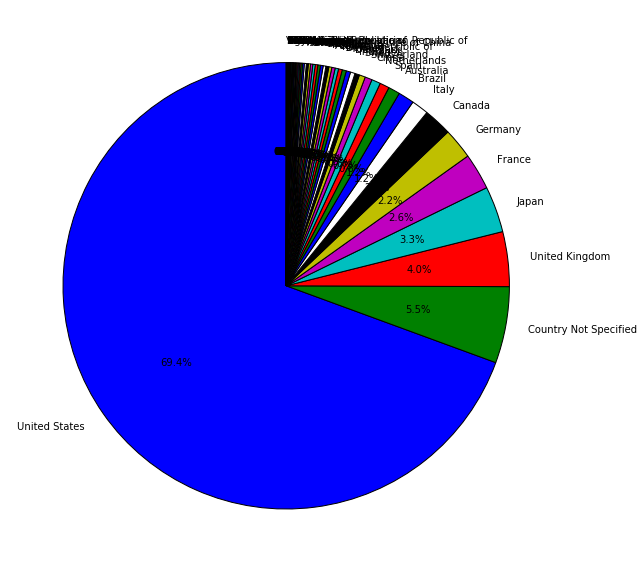

In [4]:
cnt = country_df.country.unique()
(country_df[country_df.country == cnt[0]])['count'].sum()

country_counts = pd.DataFrame({'country':cnt, \
                               'total': [(country_df[country_df.country == c])['count'].sum() for c in cnt]})
country_counts.sort_values(by='total', inplace=True, ascending=False)


fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(country_counts.total, labels=country_counts.country, autopct='%1.1f%%', startangle=90)

plt.show()

###Countries contributing to the openFDA database

Although there are over 190 recognised countries in the world, the HTTPS query returns only 100 entries.
This limitation is introduced by openFDA developers and can be overcome by using the database downloads.

For the purpose of the exercise, we can continue working with 100-entries large queries,
as the contributions of countries to the dataset decrease in exponential manner as demonstrated below.
The contributor with the least number of entries (1171) is Croatia. 
This amounts to less than 0.04% of the entries of the largest contributor (USA) with 3,160,932 entries.

The total contribution from the remaining ~90 countries then would not exceed 4% of the USA reports. 

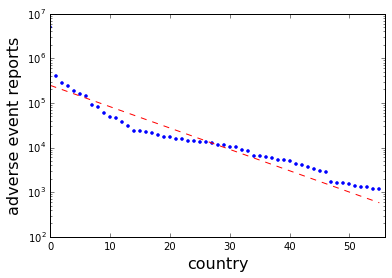

In [5]:
exponential = list(reversed(range(len(country_counts))))
exponential = [np.exp(0.11*i) for i in exponential] 
exponential = [country_counts.total.median()*float(i)/np.median(exponential) for i in exponential]
plt.semilogy(range(len(country_counts)), country_counts['total'], 'b.')
plt.semilogy(range(len(country_counts)), exponential, 'r--')
plt.xlim(0,len(country_counts))
plt.xlabel('country', fontsize=16)
plt.ylabel('adverse event reports', fontsize=16)
plt.show()

In [6]:
drug_query = 'https://api.fda.gov/drug/event.json?search=country="?"&count=patient.reaction.reactionmeddrapt.exact'

# list of dataframes with adverse effect statistics per country
res_dfs = []

country_codes = [c.lower() for c in country_df['term'] if len(c) == 2 or c == 'COUNTRY NOT SPECIFIED']

for c in country_codes:
    q = drug_query.replace('country=\"?\"', 'country=\"'+c+'\"')
    response = requests.get(q)
    data = response.json()
    data = data['results']
    df = pd.DataFrame(data)
    df.name = c
    res_dfs.append(df)



In [7]:
def prepare_overview_table(df_list):
    '''
    Merges DataFrames into one DataFrame.
    df_list: a list of dataframes with (term, count) columns
    and identical entries in "term" column.
    Returns: A DataFrame with (term, counts_df1, counts_df2, ...) columns.
    '''
    all_data = pd.DataFrame()
    all_data['term'] = df_list[0]['term']
    for d in df_list:
        d.sort_values(by='term', inplace=True)
        all_data[d.name] = d['count']
    return all_data
  


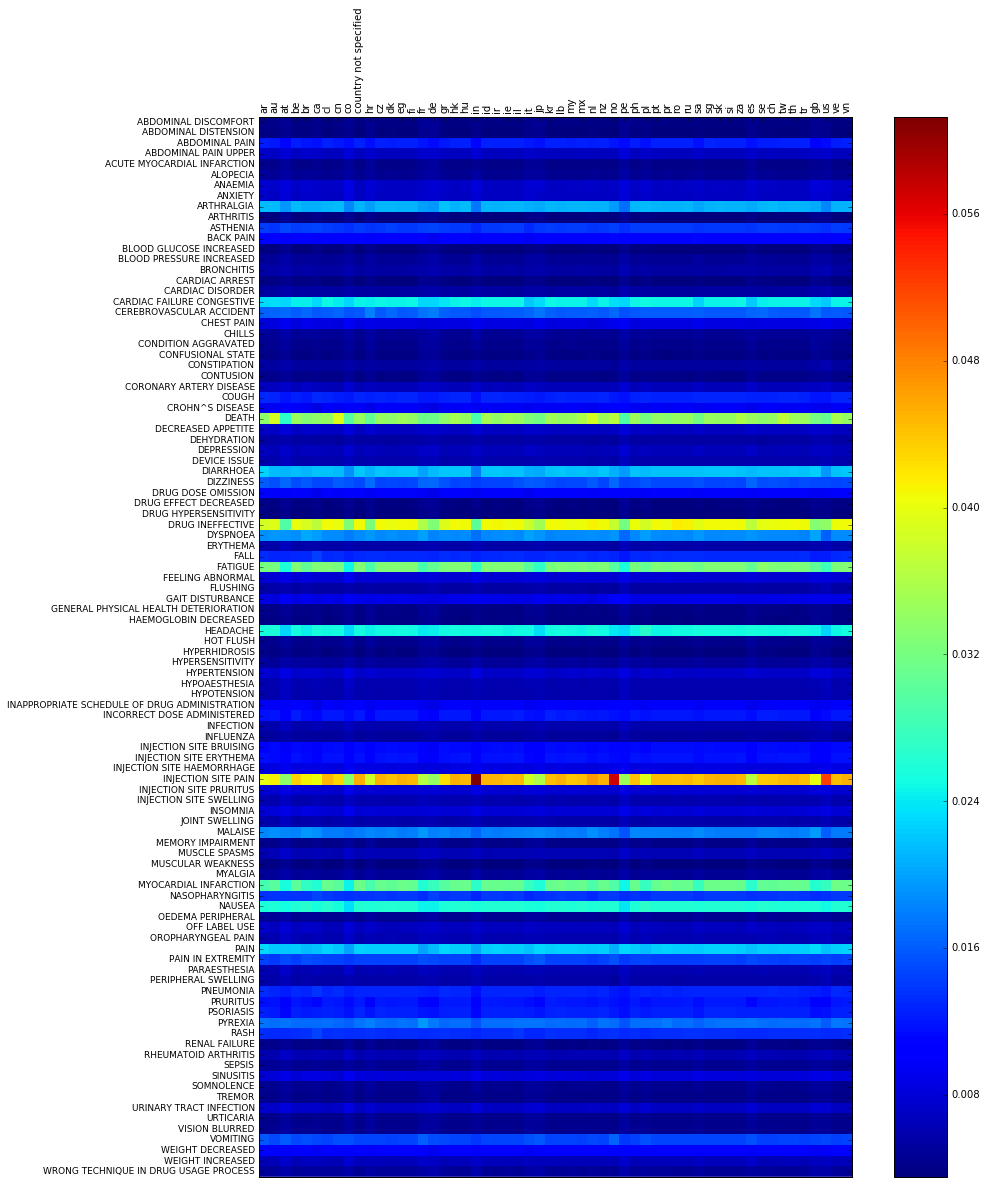

In [13]:
all_data = prepare_overview_table(res_dfs)

# normalise column(=country)-wise to the sum of all reported adverse effects
all_data_norm = all_data.iloc[:,1:].div((all_data.iloc[:,1:]).sum())

all_data_norm = pd.DataFrame(all_data_norm, columns=all_data.columns[1:])
plt.figure(figsize=(15,19))
ax = plt.gca()
ax.xaxis.set_ticks_position("top")
plt.imshow(all_data_norm, interpolation='None')
plt.yticks(range(len(all_data)), all_data.term, fontsize=9)
plt.xticks(range(len(all_data.columns[1:])), all_data.columns[1:], fontsize=10, rotation=90)
plt.colorbar()
plt.show()



In [9]:
all_data_norm.describe()

,ar,au,at,be,br,ca,cl,cn,co,country not specified,...,es,se,ch,tw,th,tr,gb,us,ve,vn
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
std,0.007833,0.008104,0.006437,0.008100,0.007760,0.007660,0.008238,0.008238,0.006373,0.008277,...,0.007421,0.008135,0.008120,0.008279,0.008264,0.008184,0.007334,0.007569,0.008246,0.008274
min,0.003775,0.003744,0.004377,0.003720,0.003693,0.004060,0.003604,0.003641,0.004423,0.003558,...,0.004081,0.003665,0.003722,0.003603,0.003613,0.003661,0.004208,0.004260,0.003638,0.003563
25%,0.005005,0.004816,0.005562,0.004791,0.004979,0.004990,0.004675,0.004819,0.005485,0.004644,...,0.005157,0.004712,0.004821,0.004687,0.004671,0.004678,0.005195,0.005166,0.004755,0.004640
50%,0.006770,0.006602,0.007530,0.006580,0.007060,0.006875,0.006612,0.006414,0.007735,0.006619,...,0.007244,0.006508,0.006493,0.006609,0.006629,0.006607,0.007010,0.007135,0.006586,0.006603
75%,0.012583,0.012164,0.011166,0.012459,0.012049,0.011963,0.012623,0.012323,0.011544,0.012647,...,0.012052,0.012515,0.012585,0.012641,0.012665,0.012663,0.011111,0.011500,0.012563,0.012659
max,0.040259,0.041433,0.033782,0.043239,0.041073,0.040342,0.044722,0.042926,0.033601,0.045261,...,0.037067,0.043579,0.043816,0.044556,0.044996,0.044273,0.040121,0.052092,0.044443,0.045152


###Top 10 adverse effects in comparison to USA

With ~69% of the FDA report entries, the USA is the major contributor to the database.
I was interested to find out, how does the USA data compare to distributions of the adverse effects in other countries.


In [10]:
# Check if the normed values are in the same order as originals
us_df = all_data[['term', 'us']]
us_df = us_df.sort_values(by=['us'], ascending=False)
top10 = us_df[:10]
print 'original data\n', us_df[:10]
top10_norm = pd.DataFrame(all_data_norm['us'])

top10_norm['term'] = all_data['term']
top10_norm = top10_norm.sort_values(by=['us'], ascending=False)
top10_norm = top10_norm[['term', 'us']]
print '\nsum-scaled data\n', top10_norm[:10]

original data
                         term      us
0  INJECTION SITE PAIN         339442
1  DRUG INEFFECTIVE            221469
2  DEATH                       201809
3  FATIGUE                     183298
4  MYOCARDIAL INFARCTION       179247
5  NAUSEA                      163418
6  HEADACHE                    149048
7  CARDIAC FAILURE CONGESTIVE  146063
8  PAIN                        143441
9  DIARRHOEA                   126783

sum-scaled data
                         term        us
0  INJECTION SITE PAIN         0.052092
1  DRUG INEFFECTIVE            0.033988
2  DEATH                       0.030971
3  FATIGUE                     0.028130
4  MYOCARDIAL INFARCTION       0.027508
5  NAUSEA                      0.025079
6  HEADACHE                    0.022874
7  CARDIAC FAILURE CONGESTIVE  0.022415
8  PAIN                        0.022013
9  DIARRHOEA                   0.019457


Top 10 entries table shape (effects*contries): (10, 56)
Are empty values present? False


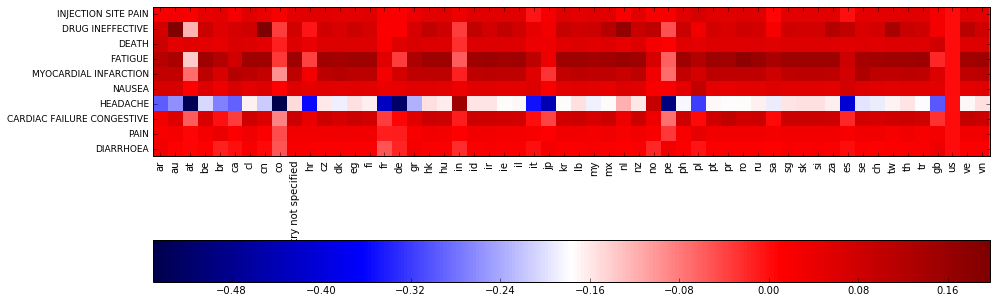

In [14]:
iix = all_data[all_data.term.isin(list(top10.term))].index
top10_all = all_data_norm.ix[iix]
print 'Top 10 entries table shape (effects*contries):', top10_all.shape
print 'Are empty values present?', all_data_norm.isnull().values.any()

top10_all_difference2us = top10_all.sub(top10_all['us'], axis=0)

# divide by max to display differences as % of the maximum value for each country.
top10_all_difference2us = top10_all_difference2us.div(top10_all.max())

plt.figure(figsize=(15,10))
plt.imshow(top10_all_difference2us, interpolation='None', cmap='seismic')
plt.yticks(range(len(top10_all_difference2us)), top10_norm.term, fontsize=9)
plt.xticks(range(len(top10_all.columns)), top10_all.columns, fontsize=10, rotation=90)
plt.colorbar(orientation='horizontal')
plt.show()


###Comments on differences in top 10 reported adverse effects with respect to the US
The largest differences (>50% of the maximum number of events/country) are observed in the reports on "headache", where all countries apart from India and Norway reported fewer events. India and Norway reported more headache events (15% and 9%, respectively). Colombia, Austria and Germany reported 55%, 54% and 52% less events than the US. 

"Pain", "diarrhoea" and "injection site pain" show very similar distributions across all countries (within 3%, 3% and 6%).

"Drug ineffective", "fatigue" and "myocardial infaction" events on average were reported more than US.


###Correlation analysis
The visualisations above are subject to normalisations and may present too many details. An alternative way to explore the differences in reports is a correlation matrix.

The plot below shows a heatmap of Pearson correlation coefficients between individual countries entries.

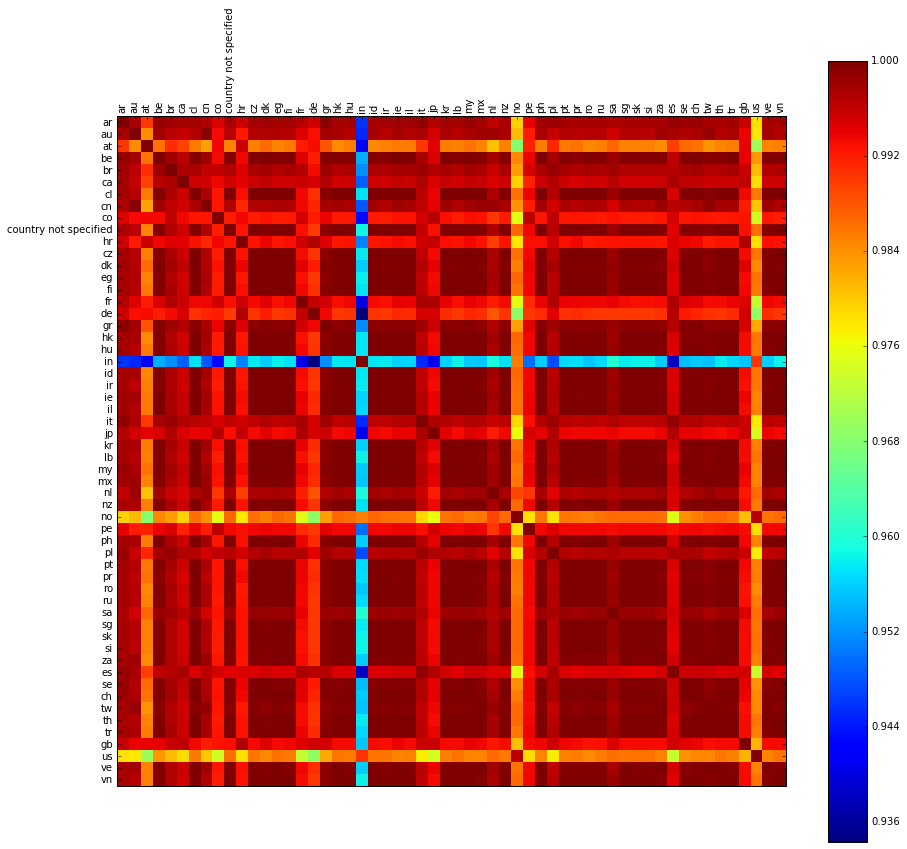

In [16]:
plt.figure(figsize=(15,14))
ax = plt.gca()
ax.xaxis.set_ticks_position("top")
plt.imshow(all_data.corr(), interpolation='None')
plt.yticks(range(len(all_data.columns[1:])), all_data.columns[1:], fontsize=10)
plt.xticks(range(len(all_data.columns[1:])), all_data.columns[1:], fontsize=10, rotation=90)
plt.colorbar()
plt.show()

###Comments on correlation analysis

The correlation coefficients in the diagram reflect inhowfar an adverse effect distribution for country X and predict an adverse effect distribution for country Y. As it loses the information about the actual effect distribution, it has a very limited application for this type of data analysis. The plot above indicates that India, Norway and US may have adverse effect distributions that differ from the rest of the population.


###OpenFDA HTTPS request limitations

OpenFDA limits the number of records per query to 100, without stating it in the API basics.
The workaround is to use *limit* and *skip* options as described below.

####Source: https://opendata.stackexchange.com/questions/11109/how-to-openfda-query-data-from-2014-to-present

... We're limited in the number of records we can display at any given time, specifically limited to 100. 

... To skip those first 100 records ... use https://api.fda.gov/food/enforcement.json?search=report_date:[20140101%20TO%2020170429]&limit=100&skip=100

... to see another 100 records, use https://api.fda.gov/food/enforcement.json?search=report_date:[20140101%20TO%2020170429]&limit=100&skip=200



### Comment on OpenFDA HTTPS interface

The use of "skip" and "limit" keywords did not help to retrieve other adverse effect descriptions.
Making do with the first 100 as a proof-of-concept.
